# Graphs

In [1]:
import json
from pathlib import Path
import os
import nibabel as nib
import numpy as np 
import nrrd
import re
from typing import Tuple
import csv
from tabulate import tabulate
from os.path import join
from utils.helper import read_nifti
from utils.metrics import dice_score_per_class, hausdorff_distance_per_class, ravd_per_class

In [2]:
# define dataset path
BASE_PATH = Path('./').resolve()
DATA_PATH = BASE_PATH / 'dataset'

project_name = 'first'  # Change here for different task names
task_name = 'Dataset004_' + project_name

TRAINING_DATASET_PATH = BASE_PATH / 'dataset/nnUNet_raw_data' / task_name / 'imagesTr'
GT_TRAINING_DATASET_PATH = BASE_PATH / 'dataset/nnUNet_raw_data' / task_name / 'labelsTr'  # Only nii.gz labels
GT_TRAINING_LABELS_PATH = BASE_PATH / 'dataset/nnUNet_raw_data' / 'extracting_labels'  # Store .nrrd label maps separately
TEST_DATASET_PATH = BASE_PATH / 'dataset/nnUNet_raw_data' / task_name / 'imagesTs'

PREDICTION_RESULTS_PATH = BASE_PATH / 'dataset/nnUNet_Prediction_Results' / task_name
TASK_PATH = BASE_PATH / 'dataset/nnUNet_raw_data' / task_name



In [7]:
import json
import torch
import pandas as pd

# Load JSON file
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

# Convert JSON data to a DataFrame
def json_to_dataframe(data):
    records = []
    for entry in data["metric_per_case"]:
        metrics = entry["metrics"]
        for case_id, values in metrics.items():
            row = {"Case_ID": case_id}
            row.update(values)
            records.append(row)
    return pd.DataFrame(records)

# Save DataFrame to Excel
def save_to_excel(df, output_path):
    df.to_excel(output_path, index=False)

# TorchScript-compatible function
def process_json(file_path, output_path):
    data = load_json(file_path)
    df = json_to_dataframe(data)
    save_to_excel(df, output_path)
    print(f"Saved Excel file to {output_path}")

# Example usage
if __name__ == "__main__":
    input_json = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_results/Dataset004_first/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_4/validation/summary.json"  # Update with actual file path
    output_excel = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/results_cleaned.xlsx"
    process_json(input_json, output_excel)

Saved Excel file to /work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/results_cleaned.xlsx


In [8]:
import json
import pandas as pd

def load_json(file_path):
    with open(file_path, "r") as file:
        return json.load(file)

def json_to_dataframe(metrics_data, label_map):
    rows = []
    
    for case in metrics_data["metric_per_case"]:
        metrics = case["metrics"]
        prediction_file = case["prediction_file"]
        reference_file = case["reference_file"]
        
        for label_num, values in metrics.items():
            label_name = label_map.get(int(label_num), f"Unknown_{label_num}")  # Get name or fallback to 'Unknown'
            row = {"Label": label_name, "Prediction File": prediction_file, "Reference File": reference_file}
            row.update(values)
            rows.append(row)
    
    return pd.DataFrame(rows)

def save_to_excel(df, output_path):
    df.to_excel(output_path, index=False)

def process_json(metrics_file, labels_file, output_path):
    metrics_data = load_json(metrics_file)
    labels_data = load_json(labels_file)
    label_map = {v: k for k, v in labels_data["labels"].items()}  # Reverse key-value pairs
    
    df = json_to_dataframe(metrics_data, label_map)
    save_to_excel(df, output_path)
    print(f"Saved Excel file to {output_path}")

# Example usage
metrics_json = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_results/Dataset004_first/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_4/validation/summary.json"  # Update with actual file path
output_excel = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/results_cleaned2.xlsx"
labels_json = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_raw_data/Dataset004_first/dataset.json"  # Update with actual file path

process_json(metrics_json, labels_json, output_excel)

Saved Excel file to /work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/results_cleaned2.xlsx


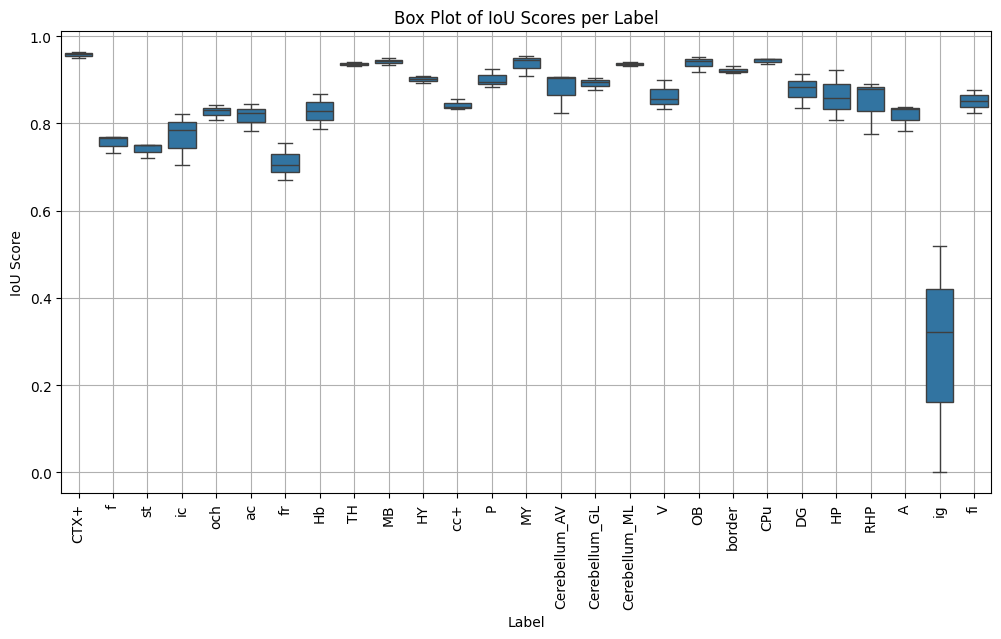

In [5]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file
file_path = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/results_cleaned3.xlsx"
df = pd.read_excel(file_path)

# Convert relevant columns to tensors (Dice, IoU)
dice_scores = torch.tensor(df["Dice"].values, dtype=torch.float32)
iou_scores = torch.tensor(df["IoU"].values, dtype=torch.float32)

# Convert back to Pandas for plotting
df_plot = pd.DataFrame({
    "Dice Score": dice_scores.numpy(),
    "IoU Score": iou_scores.numpy(),
    "Label": df["Label"]
})

# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x="Label", y="IoU Score", data=df_plot)
plt.xticks(rotation=90)
plt.title("Box Plot of IoU Scores per Label")
plt.xlabel("Label")
plt.ylabel("IoU Score")
plt.grid()

# Save the plot
plt.savefig("dice_boxplot.png", dpi=300)
plt.show()


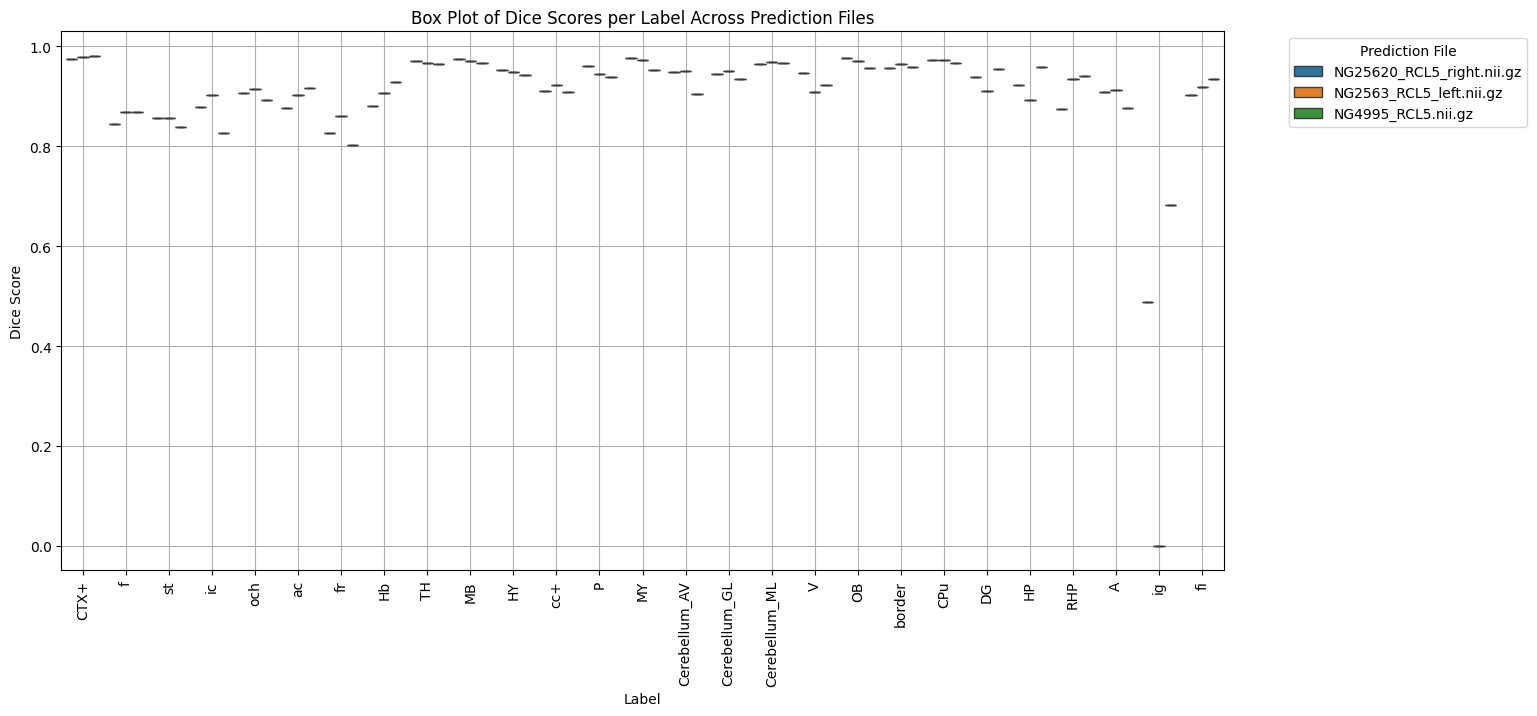

In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file
file_path = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/results_cleaned3.xlsx"
df = pd.read_excel(file_path)

# Convert Dice and IoU scores to tensors
df["Dice"] = torch.tensor(df["Dice"].values, dtype=torch.float32).numpy()
df["IoU"] = torch.tensor(df["IoU"].values, dtype=torch.float32).numpy()

# Create a grouped box plot
plt.figure(figsize=(15, 7))
sns.boxplot(x="Label", y="Dice", hue="Prediction File", data=df)

# Improve visualization
plt.xticks(rotation=90)
plt.title("Box Plot of Dice Scores per Label Across Prediction Files")
plt.xlabel("Label")
plt.ylabel("Dice Score")
plt.legend(title="Prediction File", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

# Save and show the plot
plt.savefig("dice_boxplot_grouped.png", dpi=300, bbox_inches="tight")
plt.show()


In [4]:
import pandas as pd

# Load the Excel file
file_path = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/results_cleaned3.xlsx"
df = pd.read_excel(file_path)

# Compute the total number of voxels for each row
df["Total Voxels"] = df["TP"] + df["FN"] 

# Group by label and sum the total voxels per label
voxels_per_label = df.groupby("Label")["Total Voxels"].sum().reset_index()

# Save results to a new Excel file
output_path = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/total_voxels_per_label.xlsx"
voxels_per_label.to_excel(output_path, index=False)

# Print the results
print(voxels_per_label)
print(f"Saved total voxels per label to {output_path}")


            Label  Total Voxels
0               A        729570
1             CPu      13508595
2            CTX+      38343323
3   Cerebellum_AV       2428938
4   Cerebellum_GL       4824251
5   Cerebellum_ML       8311422
6              DG       1321799
7              HP       2943666
8              HY       3745694
9              Hb        190988
10             MB       8657243
11             MY       9501947
12             OB       2947630
13              P       5604743
14            RHP       4492242
15             TH       4980829
16              V       1817481
17             ac        212814
18         border      18000219
19            cc+       4237563
20              f        167443
21             fi        633899
22             fr         47698
23             ic       1131902
24             ig          5092
25            och        277805
26             st        219881
Saved total voxels per label to /work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/total_v

In [ ]:
LABEL_DICT = {
    'mask': (0, (0, 0, 0)), 'f': (10, (0.8, 0.1, 0.1)), 'st': (11, (0.1, 0.8, 0.1)), 'ic': (12, (0.1, 0.1, 0.8)), 
    'och': (13, (1, 0.5, 0)), 'ac': (14, (1, 0, 1)), 'fr': (15, (0.5, 0, 1)), 'Hb': (16, (1, 0, 0.5)), 
    'TH': (17, (0, 1, 1)), 'HY': (18, (0.5, 1, 0)), 'MB': (19, (0.2, 0.2, 0.8)), 'CTX+': (1, (0.9, 0.9, 0.9)), 
    'P': (20, (0.3, 0.7, 0.3)), 'MY': (21, (0.5, 0.3, 0.7)), 'Cerebellum_AV': (22, (0.9, 0.8, 0.1)), 'Cerebellum_GL': (25, (0.7, 0.7, 0.2)), 
    'Cerebellum_ML': (26, (0.6, 0.3, 0.6)), 'V': (23, (0.1, 0.6, 0.9)), 'OB': (24, (0.7, 0.2, 0.2)), 'border': (27, (0.3, 0.3, 0.3)), 
    'cc+': (2, (0.2, 0.2, 0.2)), 'CPu': (3, (0.3, 0.6, 0.9)), 'DG': (4, (0.7, 0.3, 0.5)), 'HP': (5, (0.5, 0.5, 0.2)), 
    'RHP': (6, (0.2, 0.5, 0.5)), 'A': (7, (0.9, 0.6, 0.3)), 'ig': (8, (0.3, 0.3, 0.9)), 'fi': (9, (0.9, 0.3, 0.3))
}

def remap_labels(nrrd_folder, output_folder, label_dict):
    """Remap segmentation labels in an NRRD file to match LABEL_DICT."""
    for file in os.listdir(nrrd_folder):
        if file.endswith(".seg.nrrd"):
            nrrd_file = os.path.join(nrrd_folder, file)
            # Load the NRRD file
            data, header = nrrd.read(nrrd_file)
            label_names = {key.split('_')[0]: value for key, value in header.items() if key.endswith("_Name")}
            # Update the header with new colors
            for segment_key, label_name in label_names.items():
                if label_name in label_dict:
                    _, new_color = label_dict[label_name]
                    header[f"{segment_key}_Color"] = f"{new_color[0]} {new_color[1]} {new_color[2]}"
                    header[f"{segment_key}_ColorAutoGenerated"] = "0"
            
            # ✅ Save as NRRD
            nrrd_filename = os.path.splitext(file)[0] + ".nrrd"
            nrrd_filepath = os.path.join(output_folder, nrrd_filename)
            nrrd.write(nrrd_filepath, data, header=header)  # Save with original header
            print(f"✅ Saved remapped NRRD: {nrrd_filepath}")

# Example Usage
nrrd_folder = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/extra_data/file_arrangements"
output_folder ="/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/extra_data/file_arrangements"

remap_labels(nrrd_folder, output_folder, LABEL_DICT)


In [9]:
import json
import pandas as pd
import os

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

def extract_filename(path):
    return os.path.basename(path)

def json_to_dataframe(data, label_map):
    records = []
    for case in data["metric_per_case"]:
        prediction_file = extract_filename(case["prediction_file"])
        reference_file = extract_filename(case["reference_file"])
        
        for key, metrics in case["metrics"].items():
            label_name = label_map.get(int(key), f"Unknown_{key}")
            record = {"Label": label_name, "Prediction File": prediction_file, "Reference File": reference_file, **metrics}
            records.append(record)
    
    return pd.DataFrame(records)

def save_to_excel(df, output_path):
    df.to_excel(output_path, index=False)

def process_json(metric_file, dataset_file, output_path):
    metrics_data = load_json(metric_file)
    dataset_data = load_json(dataset_file)
    label_map = {v: k for k, v in dataset_data["labels"].items()}
    df = json_to_dataframe(metrics_data, label_map)
    save_to_excel(df, output_path)
    print(f"Saved Excel file to {output_path}")

# Example usage
metric_json = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_results/Dataset004_first/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_4/validation/summary.json"
dataset_json = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_preprocessed/Dataset004_first/dataset.json"
output_excel = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/results_cleaned3.xlsx"

process_json(metric_json, dataset_json, output_excel)


Saved Excel file to /work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/results_cleaned3.xlsx


# Graphs

In [4]:
import json
import pandas as pd

def load_json(file_path):
    with open(file_path, "r") as file:
        return json.load(file)

def json_to_dataframe(metrics_data, label_map):
    rows = []
    
    for case in metrics_data["metric_per_case"]:
        metrics = case["metrics"]
        prediction_file = case["prediction_file"]
        reference_file = case["reference_file"]
        
        for label_num, values in metrics.items():
            label_name = label_map.get(int(label_num), f"Unknown_{label_num}")  # Get name or fallback to 'Unknown'
            row = {"Label": label_name, "Prediction File": prediction_file, "Reference File": reference_file}
            row.update(values)
            rows.append(row)
    
    return pd.DataFrame(rows)

def save_to_excel(df, output_path):
    df.to_excel(output_path, index=False)

def process_json(metrics_file, labels_file, output_path):
    metrics_data = load_json(metrics_file)
    labels_data = load_json(labels_file)
    label_map = {v: k for k, v in labels_data["labels"].items()}  # Reverse key-value pairs
    
    df = json_to_dataframe(metrics_data, label_map)
    save_to_excel(df, output_path)
    print(f"Saved Excel file to {output_path}")

# Example usage
metrics_json = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_results/Dataset002_HCFC1/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_4/validation/summary.json"  # Update with actual file path
output_excel = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/taibur.xlsx"
labels_json = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_raw_data/Dataset002_HCFC1/dataset_old.json"  # Update with actual file path

process_json(metrics_json, labels_json, output_excel)

Saved Excel file to /work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/taibur.xlsx


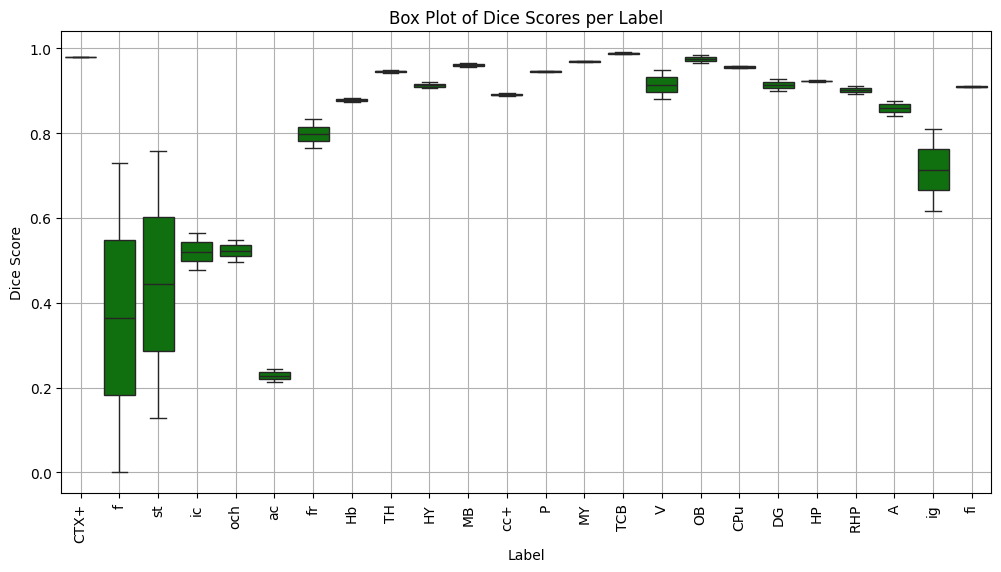

In [9]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file
file_path = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/taibur.xlsx"
df = pd.read_excel(file_path)

# Convert relevant columns to tensors (Dice, IoU)
dice_scores = torch.tensor(df["Dice"].values, dtype=torch.float32)
iou_scores = torch.tensor(df["IoU"].values, dtype=torch.float32)

# Convert back to Pandas for plotting
df_plot = pd.DataFrame({
    "Dice Score": dice_scores.numpy(),
    "IoU Score": iou_scores.numpy(),
    "Label": df["Label"]
})

# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x="Label", y="Dice Score", data=df_plot, color="green")

plt.xticks(rotation=90)
plt.title("Box Plot of Dice Scores per Label")
plt.xlabel("Label")
plt.ylabel("Dice Score")
plt.grid()

# Save the plot
# plt.savefig("dice_boxplot.png", dpi=300)
plt.show()


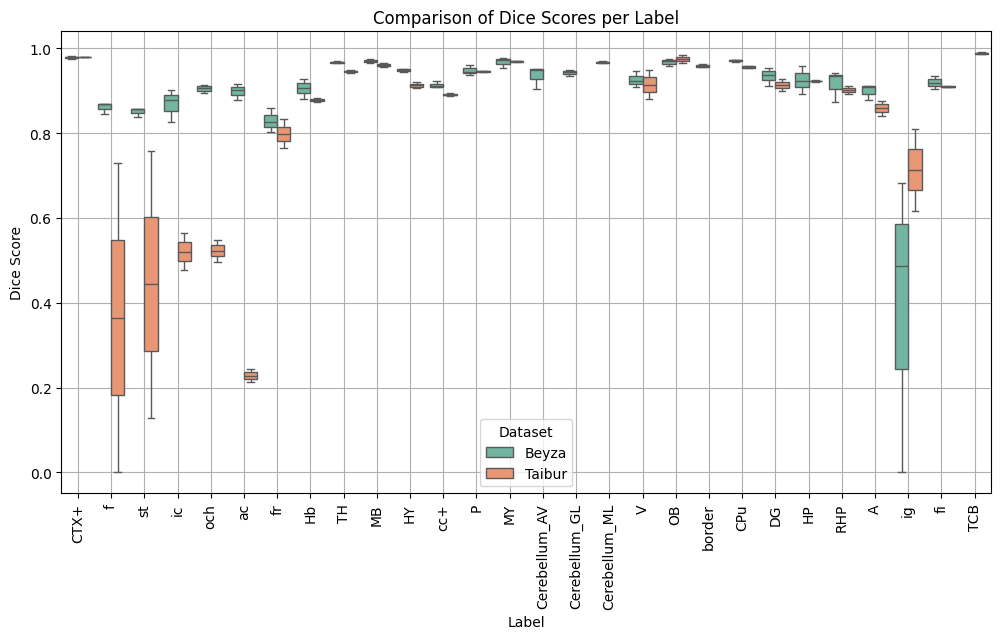

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load both Excel files
file1 = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/results_cleaned3.xlsx"  # Update with actual path
file2 = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/taibur.xlsx"  # Update with actual path

df1 = pd.read_excel(file1)
df2 = pd.read_excel(file2)

# Standardize column names (remove whitespace if any)
df1.columns = df1.columns.str.strip()
df2.columns = df2.columns.str.strip()

# Convert Dice scores to numeric (handling potential comma issues in Excel)
df1["Dice"] = df1["Dice"].astype(str).str.replace(",", ".").astype(float)
df2["Dice"] = df2["Dice"].astype(str).str.replace(",", ".").astype(float)

# Add a dataset identifier
df1["Dataset"] = "Beyza"
df2["Dataset"] = "Taibur"

# Combine both datasets for comparison
df_combined = pd.concat([df1[["Label", "Dice", "Dataset"]], df2[["Label", "Dice", "Dataset"]]])

# Plot side-by-side box plots
plt.figure(figsize=(12, 6))
sns.boxplot(x="Label", y="Dice", hue="Dataset", data=df_combined, palette="Set2")

plt.xticks(rotation=90)
plt.title("Comparison of Dice Scores per Label")
plt.xlabel("Label")
plt.ylabel("Dice Score")
plt.legend(title="Dataset")
plt.grid()

plt.show()


In [3]:
import json
import pandas as pd

def load_json(file_path):
    with open(file_path, "r") as file:
        return json.load(file)

def json_to_dataframe(metrics_data, label_map):
    rows = []
    
    for case in metrics_data["metric_per_case"]:
        metrics = case["metrics"]
        prediction_file = case["prediction_file"]
        reference_file = case["reference_file"]
        
        for label_num, values in metrics.items():
            label_name = label_map.get(int(label_num), f"Unknown_{label_num}")  # Get name or fallback to 'Unknown'
            row = {"Label": label_name, "Prediction File": prediction_file, "Reference File": reference_file}
            row.update(values)
            rows.append(row)
    
    return pd.DataFrame(rows)

def save_to_excel(df, output_path):
    df.to_excel(output_path, index=False)

def process_json(metrics_file, labels_file, output_path):
    metrics_data = load_json(metrics_file)
    labels_data = load_json(labels_file)
    label_map = {v: k for k, v in labels_data["labels"].items()}  # Reverse key-value pairs
    
    df = json_to_dataframe(metrics_data, label_map)
    save_to_excel(df, output_path)
    print(f"Saved Excel file to {output_path}")

# Example usage
metrics_json = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_results/Dataset002_HCFC1/nnUNetTrainer__nnUNetPlans__2d/fold_3/validation/summary.json"  # Update with actual file path
output_excel = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/taibur_low.xlsx"
labels_json = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_raw_data/Dataset002_HCFC1/dataset_old.json"  # Update with actual file path

process_json(metrics_json, labels_json, output_excel)

Saved Excel file to /work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/taibur_low.xlsx


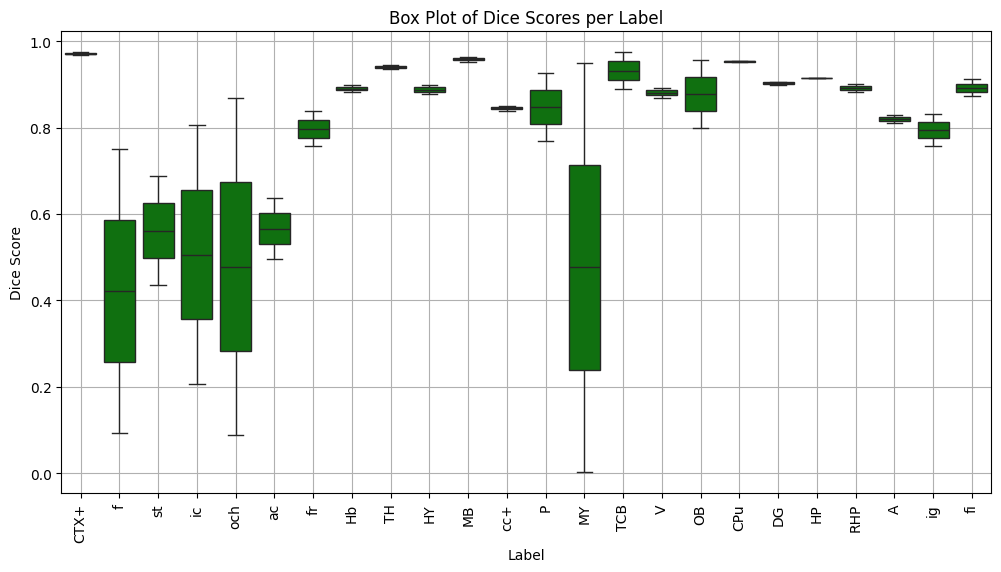

In [4]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file
file_path = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/taibur_low.xlsx"
df = pd.read_excel(file_path)

# Convert relevant columns to tensors (Dice, IoU)
dice_scores = torch.tensor(df["Dice"].values, dtype=torch.float32)
iou_scores = torch.tensor(df["IoU"].values, dtype=torch.float32)

# Convert back to Pandas for plotting
df_plot = pd.DataFrame({
    "Dice Score": dice_scores.numpy(),
    "IoU Score": iou_scores.numpy(),
    "Label": df["Label"]
})

# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x="Label", y="Dice Score", data=df_plot, color="green")

plt.xticks(rotation=90)
plt.title("Box Plot of Dice Scores per Label")
plt.xlabel("Label")
plt.ylabel("Dice Score")
plt.grid()

# Save the plot
# plt.savefig("dice_boxplot.png", dpi=300)
plt.show()


# Colorful

In [ ]:
import nibabel as nib
import numpy as np
import nrrd
import glob
import os

# Define file paths
original_nrrd_dir = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/extra_data/file_arrangements"
input_dir = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_raw_data/Dataset004_first/labelsTs"
output_dir = "/work/shared/ngmm/scripts/Beyza_Zayim/Taibur/ngmm-nnunet/dataset/nnUNet_postprocessed/Dataset004_first/result"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Get all original NRRD files
original_nrrd_files = glob.glob(os.path.join(original_nrrd_dir, "*.nrrd"))

# Create a dictionary mapping base names to full paths for NRRD files
original_nrrd_map = {}
for nrrd_file in original_nrrd_files:
    base_name = os.path.basename(nrrd_file).split('_')[0]  # Extract first part before '_'
    original_nrrd_map[base_name] = nrrd_file

# Find all NIfTI files in the input directory
nifti_files = glob.glob(os.path.join(input_dir, "*.nii.gz"))

for nifti_file in nifti_files:
    nifti_base = os.path.basename(nifti_file).split('_')[0]  # Extract first part before '_'
    
    # Match the corresponding original NRRD file
    if nifti_base in original_nrrd_map:
        original_nrrd_path = original_nrrd_map[nifti_base]

        # Load the original NRRD file and extract metadata
        original_data, original_header = nrrd.read(original_nrrd_path)

        # Extract label colors from the original NRRD file
        label_rgb = {}
        for key, value in original_header.items():
            if key.endswith("_Name"):  # Identify label names
                label_name = value
                color_key = key.replace("_Name", "_Color")  # Find corresponding color
                if color_key in original_header:
                    label_rgb[label_name] = tuple(map(float, original_header[color_key].split()))

        print(f"🔄 Processing: {nifti_file} (Matched with {original_nrrd_path})")

        # Load new NIfTI data
        img = nib.load(nifti_file)
        new_data = img.get_fdata().astype(np.int16)  # Ensure integer format

        # Copy original header
        updated_header = original_header.copy()

        # Apply the same colors to matching labels
        for label_name, rgb in label_rgb.items():
            if f"{label_name}_Name" in updated_header:
                updated_header[f"{label_name}_Color"] = f"{rgb[0]} {rgb[1]} {rgb[2]}"  
                updated_header[f"{label_name}_ColorAutoGenerated"] = "0"

        # Define output filename
        filename = os.path.basename(nifti_file).replace('.nii.gz', '.seg.nrrd')
        output_path = os.path.join(output_dir, filename)

        # Save as new NRRD file with updated metadata
        nrrd.write(output_path, new_data, updated_header)
        print(f"✅ Saved as: {output_path}")
    else:
        print(f"⚠️ No matching original NRRD found for {nifti_file}")
